In [38]:
# Dependencies
import json
import requests
import pprint
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [39]:
#Import data as pandas DF's
#Education_2016_df = pd.read_csv("Resources/2016_Education_Postcode.csv")
#Income_2016_df = pd.read_csv("Resources/2016_Income_Postcode.csv")
#VehicleCount_2016_df = pd.read_csv("Resources/2016_VehicleCount_Postcode.csv")
Education_2021_df = pd.read_csv("Resources/2021_Education_Postcode.csv")
Income_2021_df = pd.read_csv("Resources/2021_Income_Postcode.csv")
VehicleCount_2021_df = pd.read_csv("Resources/2021_VehicleCount_Postcode.csv")

#adjust name once year confirmed
FuelType_2021_df = pd.read_csv("Resources/FuelType_Postcode.csv")
#pd.read_csv("Resources/2016_FuelType_Postcode.csv")

In [66]:
def create_scatter(df, y_variable, x_variable):

    x_values = df[x_variable]
    y_values = df[y_variable]
    
    #get plot axis range for annotation location.
    ymin = df[y_variable].min()
    xmin = df[x_variable].min()

    ymax = df[y_variable].max()
    xmax = df[x_variable].max()

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    plt.scatter(
        x_values,
        y_values,
        color = 'blue',
        marker = 'o',
        s = 50,
        edgecolors = 'black')

    plt.plot(x_values, regress_values, "r-", linewidth = 1)

    #plt.annotate(line_eq, (xmin + 1, ymin + 5), fontsize =10, color = "red")

    plt.xlabel(x_variable)
    plt.ylabel(y_variable)
    plt.suptitle(f"The r-value is: {rvalue}", fontsize = 8, x = 0.2, y = 0.95)
    plt.annotate(line_eq, xy=(0.8, 1.05), fontsize =8, color = "red",
            xycoords='axes fraction', textcoords='axes fraction')

    plt.show()


In [41]:
def reshape_df(df):
    return df.pivot_table(index = ['Vehicle_type', 'Postcode'], 
                          columns = 'Fuel_type', 
                          values = 'Count').reset_index().rename_axis(None, axis=1)

In [42]:
def clean_headers(df):
    df.columns = df.columns.str.replace(" ", "_")
    return df

Clean Data

In [43]:
#Clean Headers
#Education_2016_df = clean_headers(Education_2016_df)
#Income_2016_df = clean_headers(Income_2016_df)
#VehicleCount_2016_df = clean_headers(VehicleCount_2016_df)
Education_2021_df = clean_headers(Education_2021_df)
Income_2021_df = clean_headers(Income_2021_df)
VehicleCount_2021_df = clean_headers(VehicleCount_2021_df)
FuelType_2021_df = clean_headers(FuelType_2021_df)

In [44]:
FuelType_2021_df = reshape_df(FuelType_2021_df)
#FuelType_2016_df = reshape_df(FuelType_2016_df)


In [45]:
FuelType_2021_df = FuelType_2021_df[FuelType_2021_df["Vehicle_type"] != "Total"]
FuelType_2021_df = FuelType_2021_df[FuelType_2021_df["Postcode"] != "Total"]


c:\Users\joshm\anaconda3\envs\PythonData\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Merge DFs so that Education, income, vehicle count, fuel type are in 1 df on postcode handle different postcodes that arent present in all datasets

In [46]:
#Combine the 2016 data into a single dataset.
#data_education_income_2016 = pd.merge(Education_2016_df, Income_2016_df, how="inner", on= ["Postcode", "Postcode"])
#data_complete_2016 = pd.merge(data_education_income_2016, VehicleCount_2016_df ,how="inner", on= ["Postcode", "Postcode"])
#data_complete_2016 = data_complete_2016.drop(['State','Total_y', 'Total'], axis=1)

#data_complete_2016.head()

In [47]:
Education_2021_df['Postcode'] = Education_2021_df['Postcode'].astype(int)
data_education_income_2021 = pd.merge(Education_2021_df, Income_2021_df, how="inner", on= ["Postcode", "Postcode"])
data_complete_2021 = pd.merge(data_education_income_2021, VehicleCount_2021_df ,how="inner", on= ["Postcode", "Postcode"])
data_complete_2021 = data_complete_2021.drop(['State','Total_y', 'Total'], axis=1)

Remove data for "Not Stated or Not Applicable" and subtract from Total column

In [48]:
#Education_2016_df["Total"] = Education_2016_df["Total"] - (Education_2016_df["Not_stated"] + Education_2016_df["Not_applicable"])
#Education_2016_df = Education_2016_df.drop(columns=["Not_stated", "Not_applicable"])

Education_2021_df["Total"] = Education_2021_df["Total"] - (Education_2021_df["Not_stated"] + Education_2021_df["Not_applicable"])
Education_2021_df = Education_2021_df.drop(columns=["Not_stated", "Not_applicable"])


In [49]:
#Income_2016_df["Total"] = Income_2016_df["Total"] - (Income_2016_df["Not_stated"] + Income_2016_df["Not_applicable"])
#Income_2016_df = Income_2016_df.drop(columns=["Not_stated", "Not_applicable"])

Income_2021_df["Total"] = Income_2021_df["Total"] - (Income_2021_df["Not_stated"] + Income_2021_df["Not_applicable"])
Income_2021_df = Income_2021_df.drop(columns=["Not_stated", "Not_applicable"])

In [50]:
#Same for people with multiple cars?
Education_2021_df

,Postcode,State,Postgraduate_Degree_Level,Graduate_Diploma_and_Graduate_Certificate_Level,Bachelor_Degree_Level,Advanced_Diploma_and_Diploma_Level,Certificate_III_&_IV_Level,Secondary_Education_-_Years_10_and_above,Certificate_I_&_II_Level,Secondary_Education_-_Years_9_and_below,Supplementary_Codes,Total
0,2000,NSW,3813,489,8530,3814,1137,4761,16,397,872,23818
1,2007,NSW,1134,134,2165,722,347,1426,0,163,202,6285
2,2008,NSW,1731,228,3450,752,404,2265,0,97,147,9073
3,2009,NSW,1872,346,3673,1162,712,2007,12,223,329,10324
4,2010,NSW,4003,796,9068,2185,1402,4145,6,454,602,22655
...,...,...,...,...,...,...,...,...,...,...,...,...
2636,4377,QLD/NSW,9,3,31,35,120,184,0,52,7,441
2637,4380,QLD/NSW,155,90,680,509,1292,2293,10,754,213,5993
2638,4383,QLD/NSW,3,3,15,30,112,179,0,88,12,445
2639,4385,QLD/NSW,6,21,61,67,142,350,0,168,20,839


In [51]:
#Same for vehicle types, probably want to filter out
FuelType_2021_df

,Vehicle_type,Postcode,Diesel,Electric,LPG/Dual fuel,Not Applicable,Other and unknown,Petrol,Total
0,Light Commercial Vehicles,800,1478,0,4,0,0,302,1784
1,Light Commercial Vehicles,801,6,0,0,0,0,0,7
2,Light Commercial Vehicles,802,0,0,0,0,0,0,0
3,Light Commercial Vehicles,803,3,0,0,0,0,3,4
4,Light Commercial Vehicles,804,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
5593,Passenger Vehicles,8012,0,0,3,0,0,3,3
5594,Passenger Vehicles,8051,3,0,0,0,0,0,3
5595,Passenger Vehicles,9000,0,0,0,0,0,3,3
5596,Passenger Vehicles,9726,0,0,0,0,0,0,0


Create DF's with normalised values (percentage of total)

In [52]:
Education_2021_Normalized = Education_2021_df.copy()
for col in Education_2021_Normalized.columns[2:-1]:
    Education_2021_Normalized[col] = Education_2021_Normalized[col] / Education_2021_Normalized["Total"] * 100
Education_2021_Normalized = Education_2021_Normalized.round(2)


In [53]:
FuelType_2021_Normalized = FuelType_2021_df.copy()
for col in FuelType_2021_Normalized.columns[2:-1]:
    FuelType_2021_Normalized[col] = FuelType_2021_Normalized[col] / FuelType_2021_Normalized["Total"] * 100
FuelType_2021_Normalized = FuelType_2021_Normalized.round(2)

#if total = 0 then drop row?
FuelType_2021_Normalized

,Vehicle_type,Postcode,Diesel,Electric,LPG/Dual fuel,Not Applicable,Other and unknown,Petrol,Total
0,Light Commercial Vehicles,800,82.85,0.00,0.22,0.0,0.00,16.93,1784
1,Light Commercial Vehicles,801,85.71,0.00,0.00,0.0,0.00,0.00,7
2,Light Commercial Vehicles,802,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Light Commercial Vehicles,803,75.00,0.00,0.00,0.0,0.00,75.00,4
4,Light Commercial Vehicles,804,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
5593,Passenger Vehicles,8012,0.00,0.00,100.00,0.0,0.00,100.00,3
5594,Passenger Vehicles,8051,100.00,0.00,0.00,0.0,0.00,0.00,3
5595,Passenger Vehicles,9000,0.00,0.00,0.00,0.0,0.00,100.00,3
5596,Passenger Vehicles,9726,NaN,NaN,NaN,NaN,NaN,NaN,0


In [54]:
Income_2021_Normalized = Income_2021_df.copy()
for col in Income_2021_Normalized.columns[2:-1]:
    Income_2021_Normalized[col] = Income_2021_Normalized[col] / Income_2021_Normalized["Total"] * 100
Income_2021_Normalized = Income_2021_Normalized.round(2)
Income_2021_Normalized

,Postcode,State,Negative_income,Nil_income,"$1-$149_($1-$7,799)","$150-$299_($7,800-$15,599)","$300-$399_($15,600-$20,799)","$400-$499_($20,800-$25,999)","$500-$649_($26,000-$33,799)","$650-$799_($33,800-$41,599)","$800-$999_($41,600-$51,999)","$1,000-$1,249_($52,000-$64,999)","$1,250-$1,499_($65,000-$77,999)","$1,500-$1,749_($78,000-$90,999)","$1,750-$1,999_($91,000-$103,999)","$2,000-$2,999_($104,000-$155,999)","$3,000-$3,499_($156,000-$181,999)","$3,500_or_more_($182,000_or_more)",Total
0,2000,NSW,0.66,9.80,1.35,2.42,4.32,6.31,8.79,9.13,10.13,9.92,6.45,5.19,4.28,9.59,3.09,8.54,24116
1,2007,NSW,0.86,12.37,1.84,3.79,6.16,7.15,10.63,8.90,8.55,9.97,6.76,4.89,3.96,8.24,2.61,3.46,6360
2,2008,NSW,0.74,15.54,2.82,3.53,5.28,5.23,7.49,7.21,7.35,8.51,7.26,6.09,5.18,10.35,2.66,4.80,9146
3,2009,NSW,0.39,7.51,1.48,2.63,4.04,4.24,5.67,6.23,7.35,9.02,7.75,7.09,6.11,13.84,4.78,11.92,10429
4,2010,NSW,0.33,3.95,1.14,2.24,4.32,4.87,5.09,5.55,6.78,8.54,7.83,7.89,6.64,16.17,5.27,13.41,22730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,4377,QLD/NSW,0.00,4.70,3.80,8.95,13.87,12.30,12.53,8.28,13.65,7.16,4.47,3.36,1.57,1.57,0.00,0.89,447
2637,4380,QLD/NSW,0.87,5.42,4.03,6.92,14.52,13.32,10.68,9.81,9.76,8.51,5.27,3.74,2.16,3.10,0.70,1.14,6124
2638,4383,QLD/NSW,0.00,9.53,3.39,6.99,19.70,17.80,9.53,6.14,7.84,8.05,4.03,1.91,1.48,1.27,0.85,1.27,472
2639,4385,QLD/NSW,2.07,4.83,3.22,8.39,19.31,15.86,9.66,5.17,7.36,8.51,4.60,4.14,1.95,3.33,0.34,1.38,870


In [55]:
#Calculate Education score for postcodes

Group into bigger bins for simplicity of plotting.
Make new dfs with created bins

In [56]:
#Calculate an "Income score" for each 
def calculate_income_score(row):
    values = row[2:-2].values
    weights = [0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    weighted_sum = sum([value * weight for value, weight in zip(values, weights)])
    
    return weighted_sum

Income_2021_Normalized['Income_Score'] = Income_2021_Normalized.apply(calculate_income_score, axis=1)
Income_2021_Normalized

,Postcode,State,Negative_income,Nil_income,"$1-$149_($1-$7,799)","$150-$299_($7,800-$15,599)","$300-$399_($15,600-$20,799)","$400-$499_($20,800-$25,999)","$500-$649_($26,000-$33,799)","$650-$799_($33,800-$41,599)","$800-$999_($41,600-$51,999)","$1,000-$1,249_($52,000-$64,999)","$1,250-$1,499_($65,000-$77,999)","$1,500-$1,749_($78,000-$90,999)","$1,750-$1,999_($91,000-$103,999)","$2,000-$2,999_($104,000-$155,999)","$3,000-$3,499_($156,000-$181,999)","$3,500_or_more_($182,000_or_more)",Total,Income_Score
0,2000,NSW,0.66,9.80,1.35,2.42,4.32,6.31,8.79,9.13,10.13,9.92,6.45,5.19,4.28,9.59,3.09,8.54,24116,605.67
1,2007,NSW,0.86,12.37,1.84,3.79,6.16,7.15,10.63,8.90,8.55,9.97,6.76,4.89,3.96,8.24,2.61,3.46,6360,588.77
2,2008,NSW,0.74,15.54,2.82,3.53,5.28,5.23,7.49,7.21,7.35,8.51,7.26,6.09,5.18,10.35,2.66,4.80,9146,588.88
3,2009,NSW,0.39,7.51,1.48,2.63,4.04,4.24,5.67,6.23,7.35,9.02,7.75,7.09,6.11,13.84,4.78,11.92,10429,661.24
4,2010,NSW,0.33,3.95,1.14,2.24,4.32,4.87,5.09,5.55,6.78,8.54,7.83,7.89,6.64,16.17,5.27,13.41,22730,697.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,4377,QLD/NSW,0.00,4.70,3.80,8.95,13.87,12.30,12.53,8.28,13.65,7.16,4.47,3.36,1.57,1.57,0.00,0.89,447,487.61
2637,4380,QLD/NSW,0.87,5.42,4.03,6.92,14.52,13.32,10.68,9.81,9.76,8.51,5.27,3.74,2.16,3.10,0.70,1.14,6124,518.26
2638,4383,QLD/NSW,0.00,9.53,3.39,6.99,19.70,17.80,9.53,6.14,7.84,8.05,4.03,1.91,1.48,1.27,0.85,1.27,472,449.38
2639,4385,QLD/NSW,2.07,4.83,3.22,8.39,19.31,15.86,9.66,5.17,7.36,8.51,4.60,4.14,1.95,3.33,0.34,1.38,870,488.92


In [57]:
Education_2021_Scored = Education_2021_Normalized
#Apply a multiplier based on education score to new columns
Education_2021_Scored["Postgraduate_Degree_Score"] = Education_2021_Scored["Postgraduate_Degree_Level"].apply(lambda x: x*7)
Education_2021_Scored["Graduate_Diploma_and_Graduate_Certificate_Score"] = Education_2021_Scored["Graduate_Diploma_and_Graduate_Certificate_Level"].apply(lambda x: x*6)
Education_2021_Scored["Bachelor_Degree_Score"] = Education_2021_Scored["Bachelor_Degree_Level"].apply(lambda x: x*5)
Education_2021_Scored["Advanced_Diploma_and_Diploma_Score"] = Education_2021_Scored["Advanced_Diploma_and_Diploma_Level"].apply(lambda x: x*4)
Education_2021_Scored["Certificate_III_&_IV_Level_Score"] = Education_2021_Scored["Certificate_III_&_IV_Level"].apply(lambda x: x*3)
Education_2021_Scored["Certificate_I_&_II_Level_Score"] = Education_2021_Scored["Certificate_I_&_II_Level"].apply(lambda x: x*2)
Education_2021_Scored["Secondary_Education_-_Years_10_and_above_Score"] = Education_2021_Scored["Secondary_Education_-_Years_10_and_above"].apply(lambda x: x*2)
Education_2021_Scored["Secondary_Education_-_Years_9_and_below_Score"] = Education_2021_Scored["Secondary_Education_-_Years_9_and_below"].apply(lambda x: x*1)
#Drop unneeeded columns
Education_2021_Scored = Education_2021_Scored.drop(["Postgraduate_Degree_Level", "Graduate_Diploma_and_Graduate_Certificate_Level", "Bachelor_Degree_Level", "Advanced_Diploma_and_Diploma_Level", "Certificate_III_&_IV_Level", "Certificate_I_&_II_Level", "Secondary_Education_-_Years_10_and_above", "Secondary_Education_-_Years_9_and_below"], axis=1)
#Create a column in df with summed education scores
Education_Score_List = ["Postgraduate_Degree_Score", "Graduate_Diploma_and_Graduate_Certificate_Score", "Bachelor_Degree_Score", "Advanced_Diploma_and_Diploma_Score", "Certificate_III_&_IV_Level_Score", "Certificate_I_&_II_Level_Score", "Secondary_Education_-_Years_10_and_above_Score", "Secondary_Education_-_Years_9_and_below_Score"]
Education_2021_Scored["Education_Score"] = Education_2021_Scored[Education_Score_List].sum(axis=1)


Merge Education and Income tables with fuel types, Then remove suburbs where no fuel types were recorded to disregard NaN values.

In [59]:
Income_Fueltype_2021 = pd.merge(FuelType_2021_Normalized, Income_2021_Normalized, on='Postcode')
#Merge Regional vs Metro here------------------- GJP
Income_Fueltype_2021 = Income_Fueltype_2021[Income_Fueltype_2021['Total_x'] != 0]
Income_Fueltype_2021

,Vehicle_type,Postcode,Diesel,Electric,LPG/Dual fuel,Not Applicable,Other and unknown,Petrol,Total_x,State,...,"$800-$999_($41,600-$51,999)","$1,000-$1,249_($52,000-$64,999)","$1,250-$1,499_($65,000-$77,999)","$1,500-$1,749_($78,000-$90,999)","$1,750-$1,999_($91,000-$103,999)","$2,000-$2,999_($104,000-$155,999)","$3,000-$3,499_($156,000-$181,999)","$3,500_or_more_($182,000_or_more)",Total_y,Income_Score
0,Light Commercial Vehicles,800,82.85,0.00,0.22,0.0,0.0,16.93,1784,NT,...,10.26,14.04,11.29,10.15,6.94,13.48,2.81,4.59,5733,750.97
1,Passenger Vehicles,800,19.65,0.06,0.19,0.0,0.0,80.00,5196,NT,...,10.26,14.04,11.29,10.15,6.94,13.48,2.81,4.59,5733,750.97
2,Light Commercial Vehicles,810,69.51,0.00,0.25,0.0,0.0,30.07,4762,NT,...,8.76,10.85,8.88,8.68,6.64,12.00,2.16,3.37,25161,677.32
3,Passenger Vehicles,810,14.54,0.03,0.21,0.0,0.0,85.21,17454,NT,...,8.76,10.85,8.88,8.68,6.64,12.00,2.16,3.37,25161,677.32
4,Light Commercial Vehicles,812,66.07,0.00,0.47,0.0,0.0,33.39,2965,NT,...,8.38,11.28,8.50,8.34,6.48,10.81,1.79,1.94,13263,655.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,Passenger Vehicles,7468,21.50,0.00,0.00,0.0,0.0,79.25,400,TAS,...,5.85,9.16,5.85,9.16,6.63,5.07,1.17,1.17,513,597.12
5276,Light Commercial Vehicles,7469,73.15,0.00,1.39,0.0,0.0,24.54,216,TAS,...,5.11,6.69,6.34,5.28,5.11,6.69,0.88,1.23,568,548.87
5277,Passenger Vehicles,7469,19.36,0.00,0.60,0.0,0.0,78.44,501,TAS,...,5.11,6.69,6.34,5.28,5.11,6.69,0.88,1.23,568,548.87
5278,Light Commercial Vehicles,7470,73.65,0.00,1.80,0.0,0.0,24.55,167,TAS,...,7.12,5.66,2.92,3.47,3.65,8.58,2.92,2.92,548,543.74


In [64]:
Education_Score_and_Fuel_Type_df = Education_2021_Scored.merge(FuelType_2021_Normalized, left_on ="Postcode", right_on = "Postcode")
#GJP Merge regional and metro table here too, then filter can filter for metro etc. and adjust scatter plots accordingly
Education_Score_and_Fuel_Type_df = Education_Score_and_Fuel_Type_df[Education_Score_and_Fuel_Type_df['Total_y'] != 0]
Education_Score_and_Fuel_Type_df


,Postcode,State,Supplementary_Codes,Total_x,Postgraduate_Degree_Score,Graduate_Diploma_and_Graduate_Certificate_Score,Bachelor_Degree_Score,Advanced_Diploma_and_Diploma_Score,Certificate_III_&_IV_Level_Score,Certificate_I_&_II_Level_Score,...,Secondary_Education_-_Years_9_and_below_Score,Education_Score,Vehicle_type,Diesel,Electric,LPG/Dual fuel,Not Applicable,Other and unknown,Petrol,Total_y
0,2000,NSW,3.66,23818,112.07,12.30,179.05,64.04,14.31,0.14,...,1.67,423.56,Light Commercial Vehicles,70.58,0.10,0.53,0.0,0.13,28.42,2991
1,2000,NSW,3.66,23818,112.07,12.30,179.05,64.04,14.31,0.14,...,1.67,423.56,Passenger Vehicles,15.59,0.49,0.18,0.0,5.19,78.54,17681
2,2007,NSW,3.21,6285,126.28,12.78,172.25,45.96,16.56,0.00,...,2.59,421.80,Light Commercial Vehicles,72.09,0.00,1.55,0.0,1.16,25.97,258
3,2007,NSW,3.21,6285,126.28,12.78,172.25,45.96,16.56,0.00,...,2.59,421.80,Passenger Vehicles,12.92,0.37,0.23,0.0,3.09,83.57,2136
4,2008,NSW,1.62,9073,133.56,15.06,190.10,33.16,13.35,0.00,...,1.07,436.22,Light Commercial Vehicles,65.12,0.00,1.16,0.0,0.00,34.11,258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5275,4383,QLD/NSW,2.70,445,4.69,4.02,16.85,26.96,75.51,0.00,...,19.78,228.25,Passenger Vehicles,15.08,0.00,1.12,0.0,0.00,81.56,358
5276,4385,QLD/NSW,2.38,839,5.04,15.00,36.35,31.96,50.76,0.00,...,20.02,242.57,Light Commercial Vehicles,79.57,0.00,0.54,0.0,0.00,19.89,558
5277,4385,QLD/NSW,2.38,839,5.04,15.00,36.35,31.96,50.76,0.00,...,20.02,242.57,Passenger Vehicles,27.36,0.00,0.83,0.0,0.00,71.97,603
5278,4825,QLD/NT,2.56,12779,20.02,10.20,58.10,27.24,79.05,0.28,...,9.47,281.26,Light Commercial Vehicles,80.50,0.00,0.36,0.0,0.00,19.23,5231


Create Plots

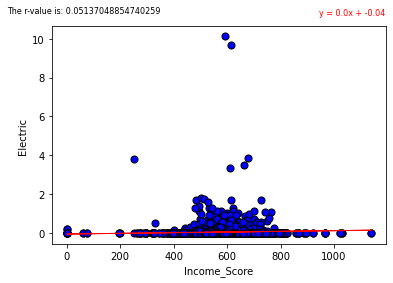

In [69]:
create_scatter(Income_Fueltype_2021, "Electric", "Income_Score")

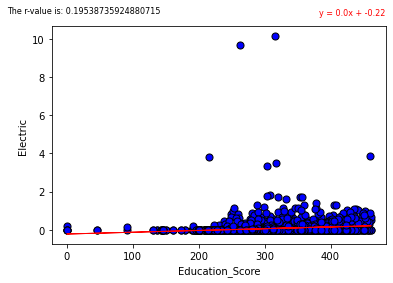

In [70]:
create_scatter(Education_Score_and_Fuel_Type_df, "Electric", "Education_Score")